In [31]:
import numpy as np
import mindspore as ms
from mindspore import nn, Tensor, context, save_checkpoint, load_checkpoint, load_param_into_net
from mindspore.dataset import ds
import matplotlib.pyplot as plt
import gzip

train_images_path = '/content/train-images-idx3-ubyte.gz'
train_labels_path = '/content/train-labels-idx1-ubyte.gz'
test_images_path = '/content/t10k-images-idx3-ubyte.gz'
test_labels_path = '/content/t10k-labels-idx1-ubyte.gz'

def load_mnist(image_file, label_file):
    with gzip.open(image_file, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
        images = images.reshape(-1, 28, 28).astype(np.float32)
    with gzip.open(label_file, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8).astype(np.int32)
    return images, labels

train_img, train_lab = load_mnist(train_images_path, train_labels_path)
test_img, test_lab = load_mnist(test_images_path, test_labels_path)

def create_dataset(images, labels, batch_size=64):
  def generator():
    for image, label in zip(images, labels):
      yield np.asarray(image), np.asarray(label)

  dataset = ds.GeneratorDataset(generator, column_names=['images', 'labels'])
  dataset = dataset.batch(batch_size)
  return dataset

# Create train and test datasets
batch_size = 32
train_dataset = create_dataset(train_img, train_lab, batch_size=batch_size)
test_dataset = create_dataset(test_img, test_lab, batch_size=batch_size)

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

class simplecnn(nn.Cell):
  def __init__(self):
    super(simplecnn, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, pad_mode='pad')
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, pad_mode='pad')
    self.flatten = nn.Flatten()
    # Change the input size of the fully connected layer to match the output of the previous layers
    self.fc = nn.Dense(64*14*14, 10)
  def construct(self, x):
    x = x.expand_dims(1)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

model = simplecnn()
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = nn.SGD(model.trainable_params(), learning_rate=0.001, momentum=0.9)
model = ms.Model(network=model, loss_fn=loss, optimizer=optimizer, metrics={"accuracy": nn.Accuracy()})
print("Started Training")
model.train(epoch=5, train_dataset=train_dataset)
accuracy = model.eval(test_dataset)["accuracy"]
print(f"Test Accuracy: {accuracy:.4f}")

[WARNING] ME(2308:135369128816640,MainProcess):2025-03-18-22:11:44.900.000 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


Started Training
Test Accuracy: 0.9809


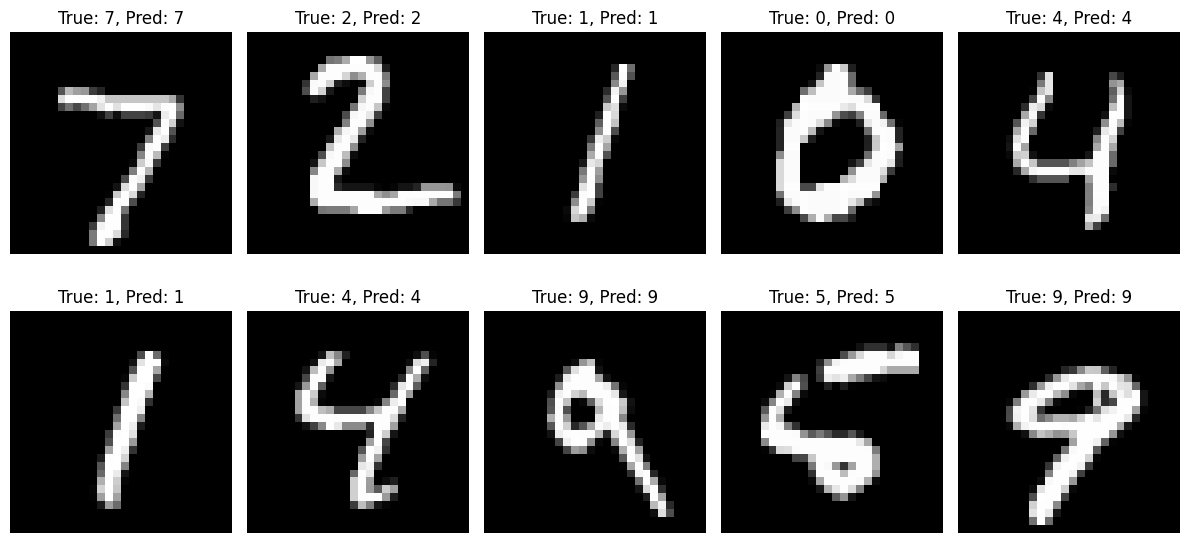

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"True: {labels[i]}, Pred: {predictions[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()